# 携程用户流失预警模型 

## 环境配置 

In [1]:
import sys
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib
import IPython
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12, 8

#忽略警号
import warnings
warnings.filterwarnings("ignore")

# 禁用科学计数法+保留两位小数
pd.set_option('display.float_format',lambda x : '%.2f' % x)
# 显示全部特征
pd.set_option('display.max_columns', None)

import random
import time

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.decomposition import PCA

## 数据导入 

In [2]:
data_train = pd.read_table('userlostprob_train.txt')

data1 = data_train.copy(deep=True)

In [3]:
data1.info()
data1.sample(10)

# data1['label'].value_counts()

# label分布
# 0    500588
# 1    189357

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689945 entries, 0 to 689944
Data columns (total 51 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   label                             689945 non-null  int64  
 1   sampleid                          689945 non-null  int64  
 2   d                                 689945 non-null  object 
 3   arrival                           689945 non-null  object 
 4   iforderpv_24h                     689945 non-null  int64  
 5   decisionhabit_user                385450 non-null  float64
 6   historyvisit_7ordernum            82915 non-null   float64
 7   historyvisit_totalordernum        386525 non-null  float64
 8   hotelcr                           689148 non-null  float64
 9   ordercanceledprecent              447831 non-null  float64
 10  landhalfhours                     661312 non-null  float64
 11  ordercanncelednum                 447831 non-null  f

,label,sampleid,d,arrival,iforderpv_24h,decisionhabit_user,historyvisit_7ordernum,historyvisit_totalordernum,hotelcr,ordercanceledprecent,landhalfhours,ordercanncelednum,commentnums,starprefer,novoters,consuming_capacity,historyvisit_avghotelnum,cancelrate,historyvisit_visit_detailpagenum,delta_price1,price_sensitive,hoteluv,businessrate_pre,ordernum_oneyear,cr_pre,avgprice,lowestprice,firstorder_bu,customereval_pre2,delta_price2,commentnums_pre,customer_value_profit,commentnums_pre2,cancelrate_pre,novoters_pre2,novoters_pre,ctrip_profits,deltaprice_pre2_t1,lowestprice_pre,uv_pre,uv_pre2,lowestprice_pre2,lasthtlordergap,businessrate_pre2,cityuvs,cityorders,lastpvgap,cr,sid,visitnum_oneyear,h
317525,0,553886,2016-05-19,2016-05-20,0,2.00,nan,6.00,1.03,0.17,nan,2.00,nan,85.50,131.00,38.00,1.90,729.00,3.00,nan,11.00,110.55,nan,6.00,nan,361.00,469.00,nan,nan,nan,nan,0.52,nan,nan,nan,nan,1.71,nan,nan,nan,nan,nan,10879.00,nan,0.87,0.08,3612.00,1.33,38,747.00,11
222850,0,396242,2016-05-15,2016-05-21,1,1.00,nan,17.00,1.02,0.02,2.00,5.00,33.00,60.00,86.00,31.00,1.00,133.00,nan,-69.00,22.00,28.36,0.12,17.00,1.02,311.00,315.00,12.00,1.70,-148.00,218.00,2.67,693.00,0.41,976.00,245.00,4.79,10.00,380.00,118.22,96.72,459.00,79332.00,0.07,5.48,0.56,2039.00,1.38,312,1911.00,15
527418,0,904138,2016-05-17,2016-05-17,0,nan,nan,nan,1.02,nan,0.00,nan,80.00,nan,127.00,nan,nan,16.00,nan,nan,nan,1.19,nan,nan,1.06,nan,77.00,nan,2.00,nan,73.00,nan,277.00,0.38,329.00,91.00,nan,9.00,32.00,1.97,16.57,149.00,nan,0.04,1.41,0.24,nan,nan,6,nan,23
172256,1,311941,2016-05-20,2016-05-20,0,1.00,nan,1.00,1.04,0.00,0.00,0.00,14.00,80.00,88.00,50.00,1.00,446.00,nan,188.00,36.00,52.44,0.06,1.00,1.04,620.00,353.00,nan,4.00,188.00,530.00,1.80,530.00,0.34,813.00,813.00,nan,0.00,432.00,20.68,20.68,432.00,23097.00,0.06,1.55,0.33,17971.00,1.17,35,1057.00,8
542574,1,929251,2016-05-21,2016-05-22,0,nan,nan,5.00,1.09,0.60,0.00,184.00,440.00,68.60,657.00,47.00,nan,852.00,nan,-43.00,55.00,35.32,0.68,5.00,1.07,495.00,80.00,nan,3.00,171.00,457.00,2.99,391.00,0.36,572.00,602.00,2.99,14.00,538.00,28.84,40.90,324.00,15214.00,0.64,20.89,4.15,13084.00,nan,2,27.00,17
526617,1,902807,2016-05-15,2016-05-15,0,14.00,1.00,2.00,1.03,0.50,nan,1.00,1977.00,40.00,2768.00,13.00,14.00,1918.00,61.00,nan,0.00,335.03,nan,2.00,nan,139.00,1317.00,13.00,nan,nan,nan,0.34,nan,nan,nan,nan,0.60,nan,nan,nan,nan,nan,762.00,nan,26.63,4.11,345.00,1.67,29,519.00,14
536723,0,919619,2016-05-18,2016-05-18,0,nan,nan,nan,1.09,nan,0.00,nan,630.00,nan,1020.00,nan,nan,488.00,nan,nan,nan,20.49,0.56,nan,1.07,nan,149.00,12.00,2.20,nan,90.00,nan,109.00,0.27,194.00,167.00,0.68,2.00,110.00,14.07,8.48,118.00,nan,0.53,2.44,0.56,17596.00,1.00,50,1203.00,20
613865,1,1047954,2016-05-15,2016-05-15,0,nan,nan,nan,1.09,nan,4.00,nan,446.00,60.00,617.00,44.00,nan,545.00,nan,120.00,83.00,18.99,0.37,nan,1.04,408.00,nan,nan,2.20,194.00,211.00,2.72,1083.00,0.21,1661.00,409.00,2.95,-11.00,288.00,30.09,97.75,214.00,nan,0.31,38.96,9.16,22721.00,nan,7,116.00,13
264110,0,465213,2016-05-21,2016-06-04,0,nan,nan,2.00,1.06,0.00,0.00,0.00,nan,100.00,11.00,100.00,nan,10.00,nan,1010.00,0.00,0.91,nan,2.00,1.03,1308.00,358.00,10.00,2.20,1009.00,37.00,1.16,58.00,0.54,42.00,28.00,8.23,nan,298.00,4.83,5.59,298.00,390834.00,0.07,0.21,0.03,141430.00,nan,3,11.00,20
683384,0,2227436,2016-05-16,2016-05-16,0,1.00,nan,2.00,1.02,0.00,0.00,0.00,1490.00,80.00,2130.00,28.00,1.00,577.00,3.00,511.00,18.00,129.47,0.21,2.00,1.05,568.00,70.00,13.00,4.20,280.00,1625.00,0.68,2164.00,0.10,3280.00,3340.00,0.67,48.00,57.00,161.38,150.30,288.00,393211.00,0.23,11.46,2.59,4659.00,1.00,67,267.00,14


In [4]:
data1_des = data1.describe()
# data1_des.to_excel('data1_des.xlsx',sheet_name='raw_des')


## 数据预处理

### 新增特征

In [5]:
# 利用好两个日期列，生成新特征 days_pre：提前预定了几天

data1['arrival'] = pd.to_datetime(data1['arrival'])
data1['d'] = pd.to_datetime(data1['d'])
data1['days_pre'] = (data1['arrival'] - data1['d']).dt.days


### 删除无效特征

In [6]:
data1.drop(['arrival', 'd', 'sampleid'], axis = 1, inplace = True)

### 异常值处理 

In [7]:
# 负值处理
data1.min()[data1.min()<0]

delta_price1            -99879.00
lowestprice                 -3.00
delta_price2            -43344.00
customer_value_profit      -24.07
ctrip_profits              -44.31
deltaprice_pre2_t1       -2296.00
dtype: float64

In [8]:
# 观察异常值分布

# rows = 2 
# cols = 3
# negs = ['delta_price1', 'lowestprice', 'delta_price2', 'customer_value_profit', 'ctrip_profits','deltaprice_pre2_t1']
# fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize = (12, 4))
# index = 0

# for i in range(rows):
#     for j in range(cols):
#         sns.distplot(data1.loc[:, negs[index]], ax=ax[i][j])
#         index = index + 1

# plt.tight_layout()

In [9]:
neg1=['delta_price1','delta_price2','lowestprice']
neg2=['customer_value_profit','ctrip_profits']
for col in neg1:
    data1.loc[data1[col]<0,col]=data1[col].median()  # 填充中位数
for col in neg2:
    data1.loc[data1[col]<0,col]=0  # 填充0

### 缺失值处理 

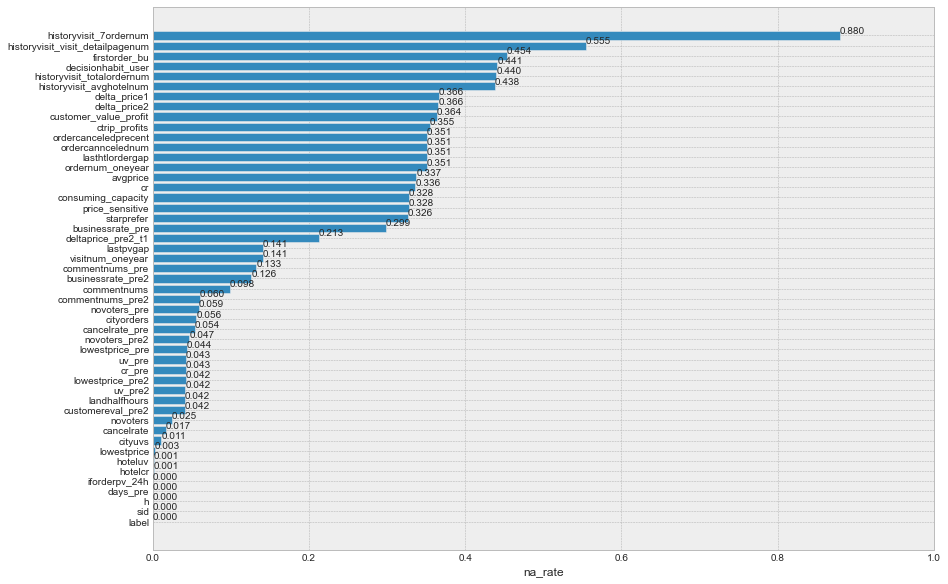

In [10]:
# 缺失值情况可视化

df = data1
na_rate = (len(df)-df.count())/len(df)  # 缺失率计算
a = na_rate.sort_values()
a1 = pd.DataFrame(a)
plt.style.use('bmh')
plt.figure(figsize = (14,10))
plt.barh(range(df.shape[1]),a1[0])
plt.xlabel('na_rate')
plt.xlim([0,1])
plt.yticks(range(df.shape[1]),a1.index.values.tolist())
for x,y in enumerate(a1[0]):
    plt.text(y,x,'%.3f'%y, va='bottom')

In [11]:
# 缺失率在80%以上的，如historyvisit_7ordernum，已经没有太多分析价值，直接去掉。

data1.drop(['historyvisit_7ordernum'], axis=1, inplace=True)

In [12]:
# 数据分布可视化

# rows = 7
# cols = 7
# fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize = (25, 25))
# index = 0

# for i in range(rows):
#     for j in range(cols):
#         if index <= 47:
#             sns.distplot(data1.iloc[:, index], ax=ax[i][j])
#             index = index + 1

# plt.tight_layout()

In [13]:
# 缺失值全部为数值型数据，结合各个特征的数据分布情况，这里用了平均值和中位数填充两种方式。
# 对于近似正态分布的数据，采用平均值填充，而近似偏态分布的数据，以及其他数值型数据，全部采用中位数填充。

fill_mean = ['businessrate_pre', 'businessrate_pre2', 'cancelrate_pre']
for col in data1.columns:
    if col in fill_mean:
        fillvalue = data1[col].mean()
        data1[col] = data1[col].fillna(fillvalue)
    else:
        fillvalue = data1[col].median()
        data1[col] = data1[col].fillna(fillvalue)

### 极值处理

In [14]:
# 有些特征明显有异常大和异常小的值,这里分别使用1%和99%分位数替换超过上下限的值.
for i in data1.columns:
    data1.loc[data1[i]<np.percentile(data1[i],1),i]=np.percentile(data1[i],1)
    data1.loc[data1[i]>np.percentile(data1[i],99),i]=np.percentile(data1[i],99)

In [15]:
data1_des_cleaned = data1.describe()
# data1_des_cleaned.to_excel('data1_des_cleaned.xlsx',sheet_name='raw_des_cleaned')

## 探索性分析

### 相关性分析 

In [16]:
# 用户特征的相关性分析
# 用户特征提取
user_features=['visitnum_oneyear','starprefer','sid','price_sensitive','ordernum_oneyear','ordercanncelednum','ordercanceledprecent','lastpvgap',
               'lasthtlordergap','landhalfhours','iforderpv_24h','historyvisit_totalordernum','historyvisit_avghotelnum','h',
               'delta_price2','delta_price1','decisionhabit_user','customer_value_profit','ctrip_profits','cr','consuming_capacity','avgprice']
# 生成用户特征的相关性矩阵
# corr_mat=data1[user_features].corr()

# 绘制用户特征的相关性矩阵热度图
# fig,ax = plt.subplots(figsize=(18, 12))
# sns.heatmap(corr_mat, xticklabels=True, yticklabels=True, square=False, linewidths=.5, annot=True, cmap='Oranges')
# plt.savefig('相关性分析 - 用户特征.jpg',dpi=400, bbox_inches='tight')
# plt.show()

In [17]:
# 酒店信息特征的相关性分析
hotel_features=['hotelcr','hoteluv','commentnums','novoters','cancelrate','lowestprice','cr_pre','uv_pre','uv_pre2','businessrate_pre',
                'businessrate_pre2','customereval_pre2','commentnums_pre','commentnums_pre2','cancelrate_pre','novoters_pre','novoters_pre2',
                'deltaprice_pre2_t1','lowestprice_pre','lowestprice_pre2','firstorder_bu','historyvisit_visit_detailpagenum']
# 生成酒店特征的相关性矩阵
# corr_mat1=data1[hotel_features].corr()

# fig,ax = plt.subplots(figsize=(18, 12))
# sns.heatmap(corr_mat1, xticklabels=True, yticklabels=True, square=False, linewidths=.5, annot=True, cmap='Oranges_r')
# plt.savefig('相关性分析 - 酒店特征.jpg',dpi=400, bbox_inches='tight')
# plt.show()

### 降维

In [18]:
# 高相关性特征分类

order_nums = ['historyvisit_totalordernum', 'ordernum_oneyear']  # 近一年用户历史订单数，用户年订单数
decision_habit = ['decisionhabit_user', 'historyvisit_avghotelnum']  # 用户决策习惯变量，近三个月用户历史日均访问酒店数
customer_value = ['ctrip_profits', 'customer_value_profit']  # 客户价值， 客户价值_近一年
price_prefer = ['delta_price1', 'delta_price2']  # 用户偏好价格
consume_level = ['consuming_capacity', 'avgprice']  # 消费能力指数，平均价格
hotel_hot = ['cancelrate', 'novoters', 'commentnums']  # 当前酒店历史订单取消率，当前酒店评分人数，当前酒店点评数
hotel_hot_pre = ["commentnums_pre","novoters_pre2","commentnums_pre2","novoters_pre"]  # 24小时历史浏览次数最多酒店点评数，24小时历史浏览酒店评分人数均值，24小时历史浏览次数最多酒店评分人数，24小时历史浏览酒店点评数均值

# PCA主成分分析降维
pca = PCA(n_components = 1)
data1['order_nums'] = pca.fit_transform(data1[order_nums])
data1['decision_habit'] = pca.fit_transform(data1[decision_habit])
data1['customer_value'] = pca.fit_transform(data1[customer_value])
data1['consume_level'] = pca.fit_transform(data1[consume_level])
data1['hotel_hot'] = pca.fit_transform(data1[hotel_hot])
data1['hotel_hot_pre'] = pca.fit_transform(data1[hotel_hot_pre])
data1['price_prefer'] = pca.fit_transform(data1[price_prefer])

data1.drop(order_nums, axis = 1, inplace=True)
data1.drop(decision_habit, axis = 1, inplace=True)
data1.drop(customer_value, axis = 1, inplace=True)
data1.drop(consume_level, axis = 1, inplace=True)
data1.drop(hotel_hot, axis = 1, inplace=True)
data1.drop(hotel_hot_pre, axis = 1, inplace=True)
data1.drop(price_prefer, axis = 1, inplace=True)

### 标准化

In [19]:

y = data1['label']
x = data1.drop('label', axis=1)

x = pd.DataFrame(x)

scaler = StandardScaler()
scaler.fit(x)

X = scaler.transform(x)


## 建模 

### 划分数据集 

In [20]:
# 由于建模时我们使用了交叉验证法 所以这里划分数据集没有实际意义
# 更新：本案例数据量足够 无需使用也无法使用交叉验证法 否则运行时间会很长

from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 420)

### 模型选择 

In [27]:
MLA = [
    # 随机森林
    ensemble.RandomForestClassifier()
    # Xgboost
    # XGBClassifier()
]

### 模型测试

In [ ]:

# 模型预测结果比较表
MLA_columns = ['MLA Name']
MLA_compare = pd.DataFrame(columns = MLA_columns)

# 各预测结果全值比较表
MLA_predict = y

row_index = 0
for alg in MLA:

    MLA_name = alg.__class__.__name__                       # 获取算法名称
    print(1.1)
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
#     MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())  # 获取算法参数
        
    alg.fit(X_train, y_train)
    print(1)
    y_prob = alg.predict_proba(X_test)[:,1]                 # 预测1类的概率
    y_pred = alg.predict(X_test)
    print(2)
    fpr,tpr,threshold = metrics.roc_curve(y_test,y_prob)    # 获取真阳率、伪阳率、阈值
    auc = metrics.auc(fpr,tpr)                        # AUC得分
    accuracy = metrics.accuracy_score(y_test,y_pred)           # 模型准确率
    print(3)
    MLA_compare[row_index, 'auc_score'] = auc
    MLA_compare[row_index, 'accuracy_score']= accuracy
    print(MLA_compare)
    MLA_predict[MLA_name] = y_pred                          # 记录每种算法的预测结果
    print(4)
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['accuracy_score'], ascending = False, inplace = True)
MLA_compare

1.1


In [ ]:
print(MLA_compare)
auc